<a href="https://colab.research.google.com/github/aiqicheng/EmotionTeller/blob/main/ClassificationBaseline_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision scikit-learn pandas pillow

import os, json, random
from pathlib import Path
import shutil


import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from statistics import mean, pstdev
import torchvision.models as models
import torchvision.transforms as T



# Process input dataset

## Load FACES data: studio headshot

Using [FACES dataset](https://faces.mpdl.mpg.de/imeji/collection/IXTdg721TwZwyZ8e?q=) as a test for building the model. This dataset contains only 75 images for standardized head shots from 6 individuals. The labels for each image is set in the filename:
- 6 classes of emotions,
- 3 age groups,
- 2 gender group

In [ ]:
# redirect to data folder
data_folder = "/content/drive/MyDrive/emo/"
%cd {data_folder}
faces_folder = data_folder + "FACES_headshots_6classes"
faces_df_path = faces_folder + "/facesdata.csv"


/content/drive/MyDrive/emo


First we should construct a metadata for the datasets from the file name.

In [ ]:
faces_df_path = faces_folder + "/facesdata.csv"

if not os.path.exists(faces_df_path):
    # Create metadata if not exist
    # Get the list of files in the current directory
    filenames = os.listdir('.')

    # Create a DataFrame from the list of filenames
    df = pd.DataFrame({'img_name': filenames})

    # Filter out the row where 'img_name' is 'facesdata.csv'
    df = df[df['img_name'] != 'facesdata.csv'].reset_index(drop=True)

    # Display the first few rows of the DataFrame
    display(df.head())

    # Map filenames to columns
    age_map     = {"m": "middle-age", "o": "old", "y": "young"}
    gender_map  = {"f": "female", "m": "male"}
    emotion_map = {"a": "anger", "d": "disgust", "f": "fear",
                  "h": "happiness", "n": "neutrality", "s": "sadness"}
    pic_map     = {"a": "a", "b": "b"}  # if you want literal set names

    # 1) pull parts from the filename
    parts = df['img_name'].str.extract(
        r'^(?P<person_id>\d+)_(?P<age>[moy])_(?P<gender>[fm])_(?P<emotion>[adfhns])_(?P<picture_set>[ab])\.jpg$'
    )

    # 2) map single letters to full names
    df = df.join(parts)
    df['age_group']  = df['age'].map(age_map)
    df['gender']     = df['gender'].map(gender_map)
    df['emotion']    = df['emotion'].map(emotion_map)
    df['picture_set'] = df['picture_set'].map(pic_map)

    # optional: reorder / cast person_id to int
    df['person_id'] = df['person_id'].astype('Int64')

    # save df to csv
    df.to_csv('facesdata.csv', index=False)
else:
    # File exist, open directly
    df = pd.read_csv(faces_df_path)
    display(df.head())
faces_df = df

,img_name,person_id,age_group,gender,emotion,picture_set
0,004_o_m_h_a.jpg,4.0,old,male,happiness,a
1,004_o_m_d_b.jpg,4.0,old,male,disgust,b
2,079_o_f_f_b.jpg,79.0,old,female,fear,b
3,116_m_m_f_b.jpg,116.0,middle-age,male,fear,b
4,066_y_m_n_a.jpg,66.0,young,male,neutrality,a


## Combine faces with cropped HGEL and RAF-DB


HGEL categories: ['Neutral', 'Happy', 'Angry', 'Surprise', 'Sad', 'Fear', 'Disgust']

FACES categories: ['neutrality', 'happiness', 'anger', 'Surprise', 'sadness', 'fear', 'disgust']

HGEL cropped columns: ['file_name',	'category',	'cropped_file_path',	'new_width',	'new_height']

FACES columns: ['img_name', 'person_id', 'age_group',	'gender',	'emotion'	'picture_set']



In [ ]:
# --- specify all path ---
data_folder = "/content/drive/MyDrive/emo/"
image_dir = data_folder + "ImageData/"
model_dir = data_folder + "BaselineModels/"
faces_folder = data_folder + "FACES_headshots_6classes"
faces_df_path = faces_folder + "/facesdata.csv"
image_df_path = model_dir + "trainval_with_crops.csv"
rafdb_folder = model_dir + "rafdb/"
rafdb_df_path = rafdb_folder + "rafdb_train.csv"
image_df = pd.read_csv(image_df_path)


In [ ]:
# ----- Inputs provided -----
image_df = pd.read_csv(image_df_path)
faces_df = pd.read_csv(faces_df_path)
rafdb_df = pd.read_csv(rafdb_df_path)


# If you've already loaded the CSVs into hgel_df / faces_df, keep these two lines commented.
# hgel_df  = pd.read_csv(HGEL_CSV)
# faces_df = pd.read_csv(FACES_CSV)

# ----- Constants / mappings -----
TARGET_CLASSES = ['Neutral', 'Happy', 'Angry', 'Surprise', 'Sad', 'Fear', 'Disgust']

# All FACES images share fixed size
FACES_W, FACES_H = 2835, 3543

# Helper: build absolute path from a value that may be absolute or relative to a CSV's directory
def make_abs_path(path_like: str, csv_dir: Path) -> str:
    p = Path(str(path_like))  # str() in case it isn't already a plain string
    return str(p if p.is_absolute() else (csv_dir / p))

# =========================================
# HGEL -> unify to ['file_path','emotion','width','height']
# =========================================
# hgel_dir = Path(HGEL_CSV).parent
# # Some HGEL CSVs store cropped_file_path as relative; normalize to absolute
# hgel_file_path = hgel_df['cropped_file_path'].apply(lambda p: make_abs_path(p, hgel_dir))
image_file_path = image_df['cropped_file_path']
# Normalize HGEL category capitalization (safety) and keep only target classes
image_emotion = image_df['category'].astype(str).str.strip().str.title()

image_out = pd.DataFrame({
    'file_path': image_file_path,
    'emotion':   image_emotion,
    'width':     image_df['new_width'].astype(int),
    'height':    image_df['new_height'].astype(int),
})
image_out = image_out[image_out['emotion'].isin(TARGET_CLASSES)].reset_index(drop=True)
image_out['source'] = "wild"

# =========================================
# FACES -> unify to ['file_path','emotion','width','height']
# =========================================
faces_dir = Path(faces_df_path).parent

# Build absolute path for each image (img_name is the filename)
faces_file_path = faces_df['img_name'].apply(lambda p: make_abs_path(p, faces_dir))

# Map FACES labels -> target labels (case-insensitive)
faces2target = {
    'neutrality': 'Neutral',
    'happiness': 'Happy',
    'anger':     'Angry',
    'surprise':  'Surprise',
    'sadness':   'Sad',
    'fear':      'Fear',
    'disgust':   'Disgust',
}

# Map emotion labels (case-insensitive) to target set
faces_emotion = (
    faces_df['emotion']
    .astype(str).str.strip().str.lower()
    .map(faces2target)
)

faces_out = pd.DataFrame({
    'file_path': faces_file_path,
    'emotion':   faces_emotion,
    'width':     FACES_W,
    'height':    FACES_H,
})

faces_out = faces_out[faces_out['emotion'].isin(TARGET_CLASSES)].reset_index(drop=True)
faces_out['source'] = "studio"


# =========================================
# RAF-DB -> unify to ['file_path','emotion','width','height']
# =========================================
rafdb_image_path = rafdb_df['file_path']
rafdb_emotion = rafdb_df['emotion'].astype(str).str.strip().str.title()
rafdb_out = pd.DataFrame({
    'file_path': rafdb_image_path,
    'emotion':   rafdb_emotion,
    'width':     rafdb_df['width'].astype(int),
    'height':    rafdb_df['height'].astype(int),
})
rafdb_out = rafdb_out[rafdb_out['emotion'].isin(TARGET_CLASSES)].reset_index(drop=True)
rafdb_out['source'] = "wild"

# =========================================
# Combine and (optionally) enforce categorical dtype
# =========================================
combined_df = pd.concat([image_out, faces_out, rafdb_out], ignore_index=True)

# Make 'emotion' a categorical column with your desired class order
combined_df['emotion'] = pd.Categorical(combined_df['emotion'], categories=TARGET_CLASSES, ordered=False)

# (Optional) quick sanity checks
print('HGEL rows:', len(image_out), '| FACES rows:', len(faces_out), '| RAF-DB rows:', len(rafdb_out), '| Combined:', len(combined_df))
print('Class distribution:\n', combined_df['emotion'].value_counts(dropna=False))

# combined_df now has exactly: ['file_path','emotion','width','height']
combined_df.head()
combined_df.to_csv(model_dir + "trainval_subset_v3.csv", index=False)

HGEL rows: 1102 | FACES rows: 72 | RAF-DB rows: 1931 | Combined: 3105
Class distribution:
 emotion
Neutral     538
Surprise    466
Happy       464
Angry       448
Sad         446
Disgust     433
Fear        310
Name: count, dtype: int64


# Model setup

## Define Dataset class
The dataset class may be generalized to other datasets.
- labels are converted to `dict: {str->int}`
- weighted class for loss calculation, just in case of imbalanced datasets

Simple data transformation is defined outside of the dataset class.

**!! To Do: Try other dataset, fix column names**

In [ ]:
class ImageDataset(Dataset):
    """
    Generic image classification dataset with built-in label map handling.

    Args:
        df: DataFrame with at least [file_path, <label_col>].
        label_col: Column name for the target (default: 'emotion').
        label2id: Optional mapping str -> int. If None, it will be built from df.
        transform: Optional torchvision transform.
        dropna_labels: Drop rows where label_col is NaN (default: True).
        strict_labels: If True and label2id is provided, rows with unknown labels are dropped.
                       If False, unknown labels raise a ValueError.
    """
    def __init__(
        self,
        df: pd.DataFrame,
        label_col: str = "emotion",
        label2id: dict | None = None,
        transform=None,
        dropna_labels: bool = True,
        strict_labels: bool = True,
    ):
        if dropna_labels:
            df = df.dropna(subset=[label_col]).reset_index(drop=True)

        self.df = df.reset_index(drop=True)
        self.label_col = label_col
        self.transform = transform

        # Build or validate label maps
        if label2id is None:
            classes = sorted(self.df[self.label_col].unique())
            self.label2id = {c: i for i, c in enumerate(classes)}
        else:
            self.label2id = dict(label2id)  # copy
            # Ensure labels in df all exist in provided mapping
            unknown = set(self.df[self.label_col].unique()) - set(self.label2id.keys())
            if unknown:
                if strict_labels:
                    # Drop unknown labels silently to keep splits consistent
                    self.df = self.df[self.df[self.label_col].isin(self.label2id.keys())].reset_index(drop=True)
                else:
                    raise ValueError(f"Found labels not in provided label2id: {unknown}")

        self.id2label = {i: c for c, i in self.label2id.items()}


    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):
      '''
        Open each image with PIL, convert to RGB and apply transformation
        Outputs:
          img: PIL image tensor shape (3, H, W)
          y: class index tensor
      '''
      row = self.df.iloc[idx]
      img_path = row["file_path"]
      img = Image.open(img_path).convert("RGB")
      domain = row["source"]   # <- set this when you build the df, don't rely on substrings
      tfm = self.transform[domain]
      img = tfm(img)
      y = torch.tensor(self.label2id[row["emotion"]], dtype=torch.long)
      return img, y

    def save_label_maps(self, out_json_path: str | Path):
      out_json_path = Path(out_json_path)
      out_json_path.parent.mkdir(parents=True, exist_ok=True)
      with open(out_json_path, "w", encoding="utf-8") as f:
          json.dump({"label2id": self.label2id, "id2label": self.id2label},
                    f, ensure_ascii=False, indent=2)

    @staticmethod
    def load_label_maps(in_json_path: str | Path) -> tuple[dict, dict]:
        with open(in_json_path, "r", encoding="utf-8") as f:
            obj = json.load(f)
        return obj["label2id"], obj["id2label"]

    def class_distribution(self) -> dict:
      """Return dict: label -> count on the CURRENT df."""
      return self.df[self.label_col].value_counts().to_dict()
    def compute_class_weights(self) -> torch.Tensor:
      """
      Compute per-class weights (shape: [num_classes]) from CURRENT df.
      Args:
          normalize: if True, scales weights so their average ~ 1.0
          eps: floor for zero counts; use 1.0 to treat empty classes as count=1
      Returns:
          torch.FloatTensor of shape (num_classes,), index = class id
      """
      counts = self.df["emotion"].value_counts().reindex(self.label2id.keys()).fillna(0).values.astype(float)
      # Inverse frequency; guard against zero
      counts[counts == 0] = 1.0
      weights = (1.0 / counts)
      weights = weights / weights.sum() * len(weights)
      # Ordered by class index
      ordered = np.zeros(len(self.label2id))
      for lab, idx in self.label2id.items():
        ordered[idx] = weights[list(self.label2id.keys()).index(lab)]
      return torch.tensor(ordered, dtype=torch.float32)


In [ ]:
class LowResSim:
    def __init__(self, min_scale=2, max_scale=5):
        self.min_scale, self.max_scale = min_scale, max_scale
    def __call__(self, img):
        w, h = img.size
        cropdim = [0.2*w,0.1*h,(1-0.2)*w,(1-0.25)*h]
        img = img.crop(cropdim)
        s = random.uniform(self.min_scale, self.max_scale)
        dw, dh = max(1, int(w/s)), max(1, int(h/s))
        img = img.resize((dw, dh), resample=Image.BICUBIC)
        img = img.resize((w, h), resample=Image.BICUBIC)
        s = random.uniform(0.05,0.2)
        img = img.resize((int(s*w),int(s*h)),resample=Image.LANCZOS) # Fix: img.resize expects tuple (width, height) and add resample
        return img

def build_transforms_train():
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    common_tail = [
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC, antialias=True),
        T.RandomHorizontalFlip(),
        T.ColorJitter(0.15, 0.15, 0.1, 0.02),
        T.ToTensor(),
        T.Normalize(mean, std),
    ]
    # Extra transforms only for studio shots
    studio_head = [LowResSim(min_scale=10, max_scale=70)]
    wild_head   = []  # keep wild faces as-is (or add mild blur/noise if you want)

    return {
        "studio": T.Compose(studio_head + common_tail),
        "wild":   T.Compose(wild_head   + common_tail),
    }

def build_transforms_val():
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    common = T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC, antialias=True),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    return {"studio": common, "wild": common}


# def build_transforms(img_size=224):
#   '''
#     Create image preprocessing for train vs. validation.
#     ImageNet normalization for ResNet/VGG backbones
#   '''
#   mean = [0.485, 0.456, 0.406]
#   std  = [0.229, 0.224, 0.225]

#   # Train transform: resize, augment, totensor, normalization
#   train_tf = T.Compose([
#       T.Resize((img_size, img_size)),
#       T.RandomHorizontalFlip(p=0.5),
#       T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)], p=0.3),
#       T.RandomRotation(degrees=10),
#       T.ToTensor(),
#       T.Normalize(mean, std),
#   ])
#   # Validation transform: resize, totensor, normalization
#   val_tf = T.Compose([
#       T.Resize((img_size, img_size)),
#       T.ToTensor(),
#       T.Normalize(mean, std),
#   ])
#   return train_tf, val_tf

## Model settup
Currently this settup includes resnet18 and vgg16.

**!! To Do: add other model backbones**

**!! To Do: test unfreeze options for future fine-tune with lower LR**



In [ ]:
def build_model(arch: str, num_classes: int, pretrained: bool = True):
  '''
    Initiate model backbone with pretrained weights.
    Alter last layer, fc, to adapt to number of classes needed.
    !! To Do: add other model backbones
  '''
  arch = arch.lower()
  if arch == "resnet18":
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    in_feats = m.fc.in_features
    m.fc = nn.Linear(in_feats, num_classes)
  elif arch == "vgg16_bn":
    m = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1 if pretrained else None)
    in_feats = m.classifier[-1].in_features
    m.classifier[-1] = nn.Linear(in_feats, num_classes)
  else:
    raise ValueError("arch must be one of: resnet18, vgg16_bn")

  return m


def train_one_epoch(model, loader, criterion, optimizer, device):
  '''
    Once pass over training set.
    Output:
      loss: average loss
      acc: average accuracy
  '''
  model.train()
  running_loss, correct, total = 0.0, 0, 0
  for x, y in loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()

    # raw score (batch size, num classes)
    logits = model(x)
    pred = logits.argmax(1)
    # weighted cross entropy
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * x.size(0)
    correct += (pred == y).sum().item()
    total += x.size(0)
  return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
  '''
    Once pass over validation set, without gradient tracking.
    Output:
      loss: average loss
      acc: average accuracy
      y_true: true labels
      y_pred: predicted labels
  '''
  model.eval()
  running_loss, correct, total = 0.0, 0, 0
  all_y, all_pred = [], []
  for x, y in loader:
    x, y = x.to(device), y.to(device)
    logits = model(x)
    loss = criterion(logits, y)
    running_loss += loss.item() * x.size(0)
    pred = logits.argmax(1)
    correct += (pred == y).sum().item()
    total += x.size(0)
    all_y.append(y.cpu().numpy())
    all_pred.append(pred.cpu().numpy())

  y_true = np.concatenate(all_y)
  y_pred = np.concatenate(all_pred)
  return running_loss / total, correct / total, y_true, y_pred



## Main training loop
Parameters can be set upon calling the main function. Results will be saved visualized at the end of the training loop.

In [ ]:
# @title
"""
def set_seed(seed: int =42):
  '''
    Set seed for reproducibility
  '''
  # keep minibatch oder the same
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  # Use deterministic kernels and no auto-tuner
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


# helper function for cross-validation
def _train_validate_once(train_df, val_df,
                         arch, epochs, batch_size, lr, img_size,
                         freeze_backbone, output_dir, seed):
    set_seed(seed)

    # -------- Build label maps from TRAIN ONLY (to avoid leakage / mismatch)
    tmp_train = train_df.dropna(subset=["emotion"])
    classes = sorted(tmp_train["emotion"].unique())
    label2id = {c: i for i, c in enumerate(classes)}

    # -------- Datasets
    train_tf, val_tf = build_transforms(img_size)
    train_ds = ImageDataset(
        train_df,
        label_col="emotion",
        label2id=label2id,
        transform=train_tf,
        dropna_labels=True,
    )
    val_ds = ImageDataset(
        val_df,
        label_col="emotion",
        label2id=label2id,
        transform=val_tf,
        dropna_labels=True,
    )
    print("Train class distribution:", train_ds.class_distribution())
    print("Val   class distribution:", val_ds.class_distribution())

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_model(arch, num_classes=len(classes), pretrained=True).to(device)

    if freeze_backbone:
        for name, p in model.named_parameters():
            p.requires_grad = False
        if arch == "resnet18":
            for p in model.fc.parameters():
                p.requires_grad = True
        else:
            for p in model.classifier[-1].parameters():
                p.requires_grad = True

    # Loss with class weights
    class_weights = train_ds.compute_class_weights().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer & scheduler
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(epochs // 3, 1), gamma=0.5)

    # Training loop
    best_val_acc, best_path = 0.0, str(Path(output_dir, "best.pt"))
    history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        print(f"Epoch {epoch:02d}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {val_loss:.4f} acc {val_acc:.3f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({"model_state": model.state_dict(),
                        "arch": arch,
                        "label2id": label2id}, best_path)
            print(f"  ↳ Saved new best to {best_path}")

        history["epoch"].append(epoch)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

    # Final evaluation using best weights
    ckpt = torch.load(best_path, map_location=device)
    model = build_model(ckpt["arch"], num_classes=len(ckpt["label2id"])).to(device)
    model.load_state_dict(ckpt["model_state"])

    _, _, y_true, y_pred = evaluate(model, val_loader, criterion, device)
    return {
        "best_val_acc": best_val_acc,
        "classes": sorted(ckpt["label2id"], key=lambda k: ckpt["label2id"][k]),
        "y_true": y_true,
        "y_pred": y_pred,
        "best_path": best_path,
        "history": history,
    }


# This function now accepts arguments directly
def main(labels_csv="trainval_subset_addfaces.csv",
         arch="resnet18",
         epochs=20, batch_size=16, lr=3e-4, img_size=224, val_size=0.2,
         seed=42, freeze_backbone=False, output_dir="runs/classification"):
  '''
    Main function to train and evaluate
    Input arguments:
      labels_csv: path to csv with labels
      images_dir: path to folder with images
    Output:
      best model saved to output_dir/best.pt
  '''

  set_seed(seed)
  output_dir += '_'+arch
  os.makedirs(output_dir, exist_ok=True)

  # -------- Load data and split by person_id
  df = pd.read_csv(labels_csv)

  # ---------- SINGLE SPLIT ----------
  # Simple stratified split by emotion (no grouping)
  train_df, val_df = train_test_split(
      df,
      test_size=val_size,
      random_state=seed,
      stratify=df["emotion"] if "emotion" in df.columns else None
  )
  train_df = train_df.reset_index(drop=True)
  val_df   = val_df.reset_index(drop=True)
  print(f"Train: {len(train_df)}  Val: {len(val_df)}  (stratified by emotion)")

  # -------- Build label maps from TRAIN ONLY (to avoid leakage / mismatch)
  tmp_train = train_df.dropna(subset=["emotion"])
  classes = sorted(tmp_train["emotion"].unique())
  label2id = {c: i for i, c in enumerate(classes)}

  # -------- Datasets (Dataset handles NaN drop + class dist)
  train_tf, val_tf = build_transforms(img_size)
  train_ds = ImageDataset(
      train_df,
      label_col="emotion",
      label2id=label2id,         # pass the mapping to lock it
      transform=train_tf,
      dropna_labels=True,
  )
  val_ds = ImageDataset(
      val_df,
      label_col="emotion",
      label2id=label2id,         # SAME mapping for val
      transform=val_tf,
      dropna_labels=True,
  )
  print("Train class distribution:", train_ds.class_distribution())
  print("Val   class distribution:", val_ds.class_distribution())

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
  val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

  # Model
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = build_model(arch, num_classes=len(classes), pretrained=True).to(device)

  if freeze_backbone:
    for name, p in model.named_parameters():
      p.requires_grad = False
    # Unfreeze classifier head only
    if arch == "resnet18":
      for p in model.fc.parameters():
        p.requires_grad = True
    else:
      for p in model.classifier[-1].parameters():
        p.requires_grad = True

  # Loss with class weights
  class_weights = train_ds.compute_class_weights().to(device)
  criterion = nn.CrossEntropyLoss(weight=class_weights)

  # Optimizer & scheduler
  trainable_params = [p for p in model.parameters() if p.requires_grad]
  optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(epochs // 3, 1), gamma=0.5)

  # Training loop
  best_val_acc, best_path = 0.0, str(Path(output_dir, "best.pt"))
  history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
  }
  for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    scheduler.step()

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f}")

    # record best and early stopping
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      torch.save({"model_state": model.state_dict(),
                  "arch": arch,
                  "label2id": label2id}, best_path)
      print(f"  ↳ Saved new best to {best_path}")

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

  # Final evaluation on val with best weights
  ckpt = torch.load(best_path, map_location=device)
  model = build_model(ckpt["arch"], num_classes=len(ckpt["label2id"])).to(device)
  model.load_state_dict(ckpt["model_state"])

  _, _, y_true, y_pred = evaluate(model, val_loader, criterion, device)
  print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=classes, digits=4))
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  plt.figure(figsize=(6,6))
  disp.plot(cmap=plt.cm.Blues, values_format="d",  ax=plt.gca(), colorbar=False)
  plt.tight_layout()

  cm_png = Path(output_dir, "confusion_matrix.png")
  plt.savefig(cm_png, dpi=150)

  # visualize result
  def visualize_result(history: dict):

    # ---- Save metrics to CSV
    hist_df = pd.DataFrame(history)
    hist_csv = Path(output_dir, "training_history.csv")
    hist_df.to_csv(hist_csv, index=False)
    print(f"Saved history to {hist_csv}")

    # ---- Plot loss and accuracy
    plt.figure(figsize=(7,5))
    plt.plot(history["epoch"], history["train_loss"], label="train loss")
    plt.plot(history["epoch"], history["val_loss"],   label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Val Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    loss_png = Path(output_dir, "loss_curve.png")
    plt.tight_layout()
    plt.savefig(loss_png, dpi=150)
    #plt.close()
    print(f"Saved loss curve to {loss_png}")

    plt.figure(figsize=(7,5))
    plt.plot(history["epoch"], history["train_acc"], label="train acc")
    plt.plot(history["epoch"], history["val_acc"],   label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Val Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    acc_png = Path(output_dir, "accuracy_curve.png")
    plt.tight_layout()
    plt.savefig(acc_png, dpi=150)
    #plt.close()
    print(f"Saved accuracy curve to {acc_png}")

  visualize_result(history)
  plt.show()
"""

'\ndef set_seed(seed: int =42):\n  \'\'\'\n    Set seed for reproducibility\n  \'\'\'\n  # keep minibatch oder the same\n  random.seed(seed)\n  np.random.seed(seed)\n  torch.manual_seed(seed)\n  torch.cuda.manual_seed_all(seed)\n  # Use deterministic kernels and no auto-tuner\n  torch.backends.cudnn.deterministic = True\n  torch.backends.cudnn.benchmark = False\n\n\n# helper function for cross-validation\ndef _train_validate_once(train_df, val_df,\n                         arch, epochs, batch_size, lr, img_size,\n                         freeze_backbone, output_dir, seed):\n    set_seed(seed)\n\n    # -------- Build label maps from TRAIN ONLY (to avoid leakage / mismatch)\n    tmp_train = train_df.dropna(subset=["emotion"])\n    classes = sorted(tmp_train["emotion"].unique())\n    label2id = {c: i for i, c in enumerate(classes)}\n\n    # -------- Datasets\n    train_tf, val_tf = build_transforms(img_size)\n    train_ds = ImageDataset(\n        train_df,\n        label_col="emotion",\n 

In [ ]:
def _save_history_plots(history: dict, out_dir: str, prefix: str = ""):
    """
    Save per-epoch metrics to CSV and loss/acc plots into out_dir.
    history = {"epoch":[], "train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # CSV
    hist_df = pd.DataFrame(history)
    hist_csv = out_dir / f"{prefix}training_history.csv"
    hist_df.to_csv(hist_csv, index=False)
    print(f"Saved history to {hist_csv}")

    # Loss plot
    plt.figure(figsize=(7,5))
    plt.plot(history["epoch"], history["train_loss"], label="train loss")
    plt.plot(history["epoch"], history["val_loss"],   label="val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train vs Val Loss")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    loss_png = out_dir / f"{prefix}loss_curve.png"
    plt.savefig(loss_png, dpi=150)
    print(f"Saved loss curve to {loss_png}")

    # Acc plot
    plt.figure(figsize=(7,5))
    plt.plot(history["epoch"], history["train_acc"], label="train acc")
    plt.plot(history["epoch"], history["val_acc"],   label="val acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Train vs Val Accuracy")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    acc_png = out_dir / f"{prefix}accuracy_curve.png"
    plt.savefig(acc_png, dpi=150)
    print(f"Saved accuracy curve to {acc_png}")

# helper function for cross-validation
def _train_validate_once(train_df, val_df,
                         arch, epochs, batch_size, lr, img_size,
                         freeze_backbone, output_dir, seed):
    set_seed(seed)

    # -------- Build label maps from TRAIN ONLY (to avoid leakage / mismatch)
    tmp_train = train_df.dropna(subset=["emotion"])
    classes = sorted(tmp_train["emotion"].unique())
    label2id = {c: i for i, c in enumerate(classes)}

    # -------- Datasets
    train_tfms = build_transforms_train()
    val_tfms   = build_transforms_val()
    train_ds = ImageDataset(
        train_df,
        label_col="emotion",
        label2id=label2id,
        transform=train_tfms,
        dropna_labels=True,
    )
    val_ds = ImageDataset(
        val_df,
        label_col="emotion",
        label2id=label2id,
        transform=val_tfms,
        dropna_labels=True,
    )
    print("Train class distribution:", train_ds.class_distribution())
    print("Val   class distribution:", val_ds.class_distribution())

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_model(arch, num_classes=len(classes), pretrained=True).to(device)

    if freeze_backbone:
        for name, p in model.named_parameters():
            p.requires_grad = False
        if arch == "resnet18":
            for p in model.fc.parameters():
                p.requires_grad = True
        else:
            for p in model.classifier[-1].parameters():
                p.requires_grad = True

    # Loss with class weights
    class_weights = train_ds.compute_class_weights().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer & scheduler
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(epochs // 3, 1), gamma=0.5)

    # Training loop
    best_val_acc, best_path = 0.0, str(Path(output_dir, "best.pt"))
    epochs_no_improve = 0
    early_stop_patience = 20  # set early stopping point
    history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        print(f"Epoch {epoch:02d}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {val_loss:.4f} acc {val_acc:.3f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0 # reset counter
            torch.save({"model_state": model.state_dict(),
                        "arch": arch,
                        "label2id": label2id}, best_path)
            print(f"  ↳ Saved new best to {best_path}")
        else:
            epochs_no_improve += 1

        history["epoch"].append(epoch)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping after {epochs_no_improve} epochs without improvement.")
            break

    # Final evaluation using best weights
    ckpt = torch.load(best_path, map_location=device)
    model = build_model(ckpt["arch"], num_classes=len(ckpt["label2id"])).to(device)
    model.load_state_dict(ckpt["model_state"])
    _, _, y_true, y_pred = evaluate(model, val_loader, criterion, device)

    _save_history_plots(history, output_dir)

    return {
        "best_val_acc": best_val_acc,
        "classes": sorted(ckpt["label2id"], key=lambda k: ckpt["label2id"][k]),
        "y_true": y_true,
        "y_pred": y_pred,
        "best_path": best_path,
        "history": history,
    }

In [ ]:
def set_seed(seed: int =42):
  '''
    Set seed for reproducibility
  '''
  # keep minibatch oder the same
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  # Use deterministic kernels and no auto-tuner
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False



# --- main() optionally does K-fold CV  ---
def main(labels_csv="trainval_subset_v3.csv", arch="resnet18",
         epochs=20, batch_size=16, lr=3e-4, img_size=224, val_size=0.2,
         seed=42, freeze_backbone=False, output_dir="runs/classification",
         cv=None,            # None or int (e.g., 5)
         group_col=None,
         cv_seed=None):      # shuffle seed for StratifiedKFold
    """
    If cv is None or 1: behaves like before (single stratified split).
    If cv >= 2: runs K-fold (Stratified by 'emotion' or GroupKFold if group_col provided).
    """
    set_seed(seed)
    output_dir += '_' + arch
    os.makedirs(output_dir, exist_ok=True)

    df = pd.read_csv(labels_csv)

    # ---------- SINGLE SPLIT (unchanged behavior) ----------
    if cv is None or cv == 1:
        train_df, val_df = train_test_split(
            df,
            test_size=val_size,
            random_state=seed,
            stratify=df["emotion"] if "emotion" in df.columns else None
        )
        train_df = train_df.reset_index(drop=True)
        val_df   = val_df.reset_index(drop=True)
        print(f"Train: {len(train_df)}  Val: {len(val_df)}  (stratified by emotion)")

        fold_dir = Path(output_dir) / "foldsingle"
        fold_dir.mkdir(parents=True, exist_ok=True)
        result = _train_validate_once(
            train_df, val_df, arch, epochs, batch_size, lr, img_size,
            freeze_backbone, str(fold_dir), seed
        )
        plt.show()

        # report
        print("\nClassification report:\n",
              classification_report(result["y_true"], result["y_pred"],
                                    target_names=result["classes"], digits=4))
        cm = confusion_matrix(result["y_true"], result["y_pred"])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=result["classes"])
        plt.figure(figsize=(6,6))
        disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca(), colorbar=False)
        plt.tight_layout()
        cm_png = Path(fold_dir, "confusion_matrix.png")
        plt.savefig(cm_png, dpi=150)
        print(f"Best fold0 model: {result['best_path']}  | best_val_acc={result['best_val_acc']:.4f}")
        return

    # ---------- K-FOLD CV ----------
    assert "emotion" in df.columns, "For stratified CV, the dataframe must have an 'emotion' column."
    y = df["emotion"].values
    X_idx = np.arange(len(df))
    cv_seed = seed if cv_seed is None else cv_seed

    if group_col is not None:
        assert group_col in df.columns, f"group_col '{group_col}' not in dataframe."
        groups = df[group_col].values
        splitter = GroupKFold(n_splits=cv)
        split_iter = splitter.split(X_idx, y=None, groups=groups)
        split_name = f"GroupKFold({cv}) on {group_col}"
    else:
        splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=cv_seed)
        split_iter = splitter.split(X_idx, y)
        split_name = f"StratifiedKFold({cv}) by emotion"

    print(f"\nRunning {split_name} ...\n")

    fold_accs = []
    all_histories = []
    for fold, (tr_idx, va_idx) in enumerate(split_iter):
        print(f"==== Fold {fold+1}/{cv} ====")
        train_df = df.iloc[tr_idx].reset_index(drop=True)
        val_df   = df.iloc[va_idx].reset_index(drop=True)

        fold_dir = Path(output_dir) / f"fold{fold}"
        fold_dir.mkdir(parents=True, exist_ok=True)

        result = _train_validate_once(
            train_df, val_df, arch, epochs, batch_size, lr, img_size,
            freeze_backbone, str(fold_dir), seed
        )

        # per-fold report & confusion matrix
        print("\nClassification report (fold {}/{}):\n".format(fold+1, cv),
              classification_report(result["y_true"], result["y_pred"],
                                    target_names=result["classes"], digits=4))
        cm = confusion_matrix(result["y_true"], result["y_pred"])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=result["classes"])
        plt.figure(figsize=(6,6))
        disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca(), colorbar=False)
        plt.tight_layout()
        plt.savefig(Path(fold_dir, "confusion_matrix.png"), dpi=150)

        fold_accs.append(result["best_val_acc"])
        print(f"Best model for fold{fold}: {result['best_path']}  | best_val_acc={result['best_val_acc']:.4f}")

        #fold-tagged history for aggregation
        hist = pd.DataFrame(result["history"])
        hist["fold"] = fold
        all_histories.append(hist)

    # ---- CV summary (acc mean/std) ----
    print("\n==== CV Summary ====")
    print("Fold accuracies:", [f"{a:.4f}" for a in fold_accs])
    print(f"Mean acc = {mean(fold_accs):.4f}  |  Std (population) = {pstdev(fold_accs):.4f}")


    # ---- Write aggregated CV history ----
    cv_hist = pd.concat(all_histories, ignore_index=True)
    cv_hist_csv = Path(output_dir) / "cv_training_history.csv"
    cv_hist.to_csv(cv_hist_csv, index=False)
    print(f"Saved aggregated CV history to {cv_hist_csv}")

    # after the CV loop finishes
    best_fold = int(np.argmax(fold_accs))
    best_path_overall = Path(output_dir) / f"fold{best_fold}" / "best.pt"

    # Optionally copy to a canonical name
    final_path = Path(output_dir) / "best_overall.pt"
    shutil.copyfile(best_path_overall, final_path)
    print(f"Selected best fold = {best_fold}  |  saved as {final_path}")

    # (Optional) quick aggregate plots (e.g., mean across folds per epoch)
    try:
        agg = cv_hist.groupby("epoch", as_index=False).agg({
            "train_loss":"mean","val_loss":"mean","train_acc":"mean","val_acc":"mean"
        })
        _save_history_plots(agg.to_dict(orient="list"), output_dir, prefix="cv_mean_")
    except Exception as e:
        print(f"Skipping CV-mean plots: {e}")

    plt.show()


## Call training function
- train & val once, early stop at 10 non-improving epochs
- cross validation 5 folds

/content/drive/MyDrive/emo/BaselineModels
Train: 2484  Val: 621  (stratified by emotion)
Train class distribution: {'Neutral': 430, 'Surprise': 373, 'Happy': 371, 'Angry': 359, 'Sad': 357, 'Disgust': 346, 'Fear': 248}
Val   class distribution: {'Neutral': 108, 'Surprise': 93, 'Happy': 93, 'Sad': 89, 'Angry': 89, 'Disgust': 87, 'Fear': 62}
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 236MB/s]


Epoch 01/300 | train loss 1.9696 acc 0.175 | val loss 1.9150 acc 0.221
  ↳ Saved new best to runs/classification_resnet18/foldsingle/best.pt
Epoch 02/300 | train loss 1.8457 acc 0.258 | val loss 1.8220 acc 0.266
  ↳ Saved new best to runs/classification_resnet18/foldsingle/best.pt
Epoch 03/300 | train loss 1.7703 acc 0.293 | val loss 1.7684 acc 0.287
  ↳ Saved new best to runs/classification_resnet18/foldsingle/best.pt
Epoch 04/300 | train loss 1.7192 acc 0.335 | val loss 1.7172 acc 0.338
  ↳ Saved new best to runs/classification_resnet18/foldsingle/best.pt
Epoch 05/300 | train loss 1.6854 acc 0.349 | val loss 1.6805 acc 0.330
Epoch 06/300 | train loss 1.6408 acc 0.378 | val loss 1.6553 acc 0.351
  ↳ Saved new best to runs/classification_resnet18/foldsingle/best.pt
Epoch 07/300 | train loss 1.6291 acc 0.386 | val loss 1.6322 acc 0.370
  ↳ Saved new best to runs/classification_resnet18/foldsingle/best.pt
Epoch 08/300 | train loss 1.5817 acc 0.409 | val loss 1.5968 acc 0.364
Epoch 09/300

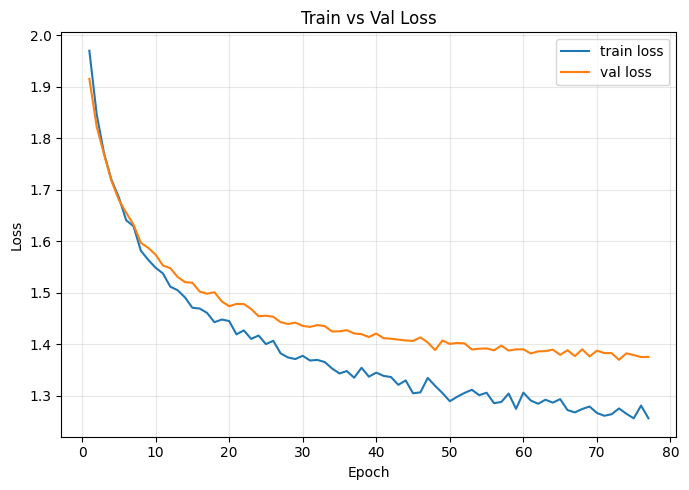

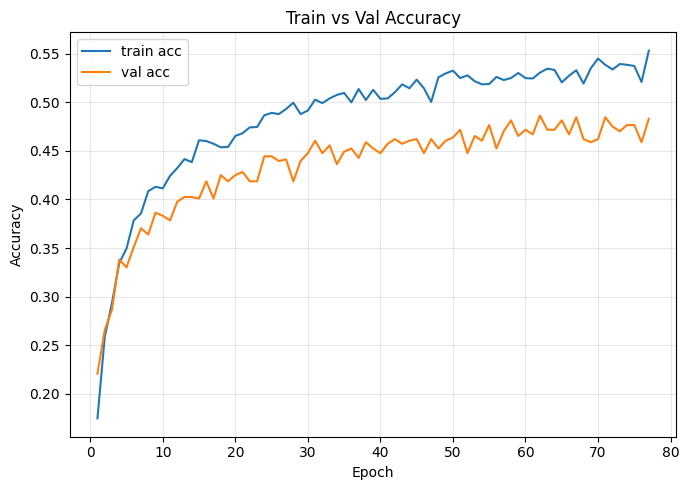


Classification report:
               precision    recall  f1-score   support

       Angry     0.4930    0.3933    0.4375        89
     Disgust     0.3571    0.2874    0.3185        87
        Fear     0.5283    0.4516    0.4870        62
       Happy     0.5632    0.5269    0.5444        93
     Neutral     0.5556    0.6019    0.5778       108
         Sad     0.4000    0.5169    0.4510        89
    Surprise     0.5000    0.5806    0.5373        93

    accuracy                         0.4863       621
   macro avg     0.4853    0.4798    0.4791       621
weighted avg     0.4866    0.4863    0.4831       621

Best fold0 model: runs/classification_resnet18/foldsingle/best.pt  | best_val_acc=0.4863


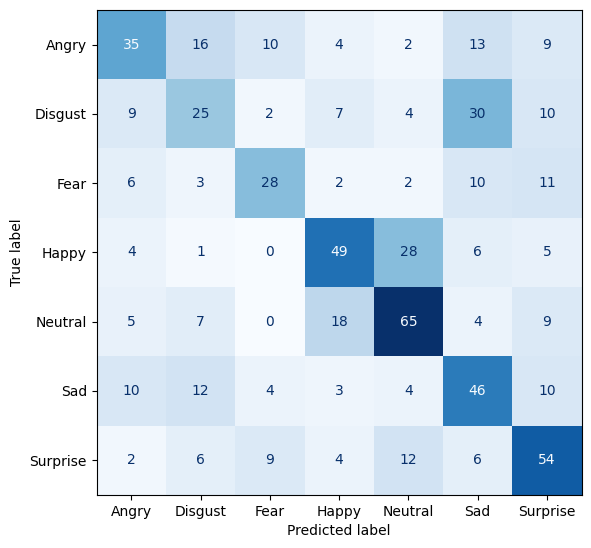

In [ ]:
# """
# no cross-validation
# Define your arguments here
my_arch = "resnet18"
my_cv = 1
my_epochs = 300
my_lr = 1e-4
my_freeze = True

# Call main with your arguments
%cd {model_dir}
main(arch=my_arch, epochs=my_epochs, cv=my_cv, lr=my_lr, freeze_backbone=my_freeze)
# """

/content/drive/MyDrive/emo/BaselineModels

Running StratifiedKFold(5) by emotion ...

==== Fold 1/5 ====
Train class distribution: {'Neutral': 431, 'Surprise': 373, 'Happy': 371, 'Angry': 358, 'Sad': 356, 'Disgust': 347, 'Fear': 248}
Val   class distribution: {'Neutral': 107, 'Happy': 93, 'Surprise': 93, 'Angry': 90, 'Sad': 90, 'Disgust': 86, 'Fear': 62}
Epoch 01/200 | train loss 1.8837 acc 0.235 | val loss 1.7859 acc 0.280
  ↳ Saved new best to runs/classification_resnet18/fold0/best.pt
Epoch 02/200 | train loss 1.7004 acc 0.343 | val loss 1.6886 acc 0.337
  ↳ Saved new best to runs/classification_resnet18/fold0/best.pt
Epoch 03/200 | train loss 1.6035 acc 0.373 | val loss 1.6031 acc 0.380
  ↳ Saved new best to runs/classification_resnet18/fold0/best.pt
Epoch 04/200 | train loss 1.5371 acc 0.424 | val loss 1.5721 acc 0.407
  ↳ Saved new best to runs/classification_resnet18/fold0/best.pt
Epoch 05/200 | train loss 1.5033 acc 0.432 | val loss 1.5306 acc 0.433
  ↳ Saved new best to runs/c

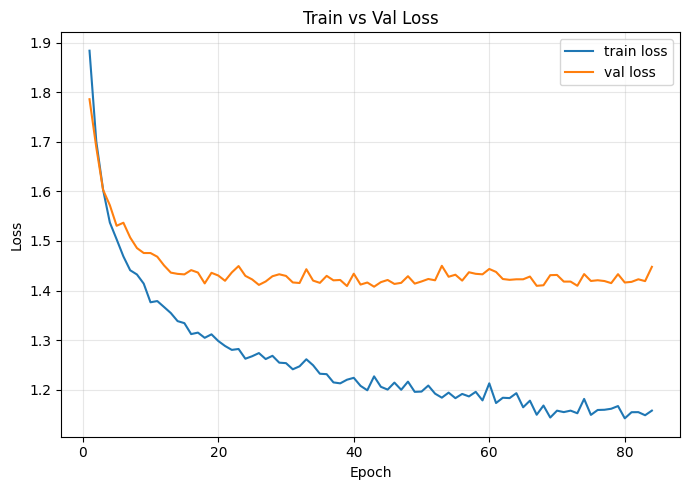

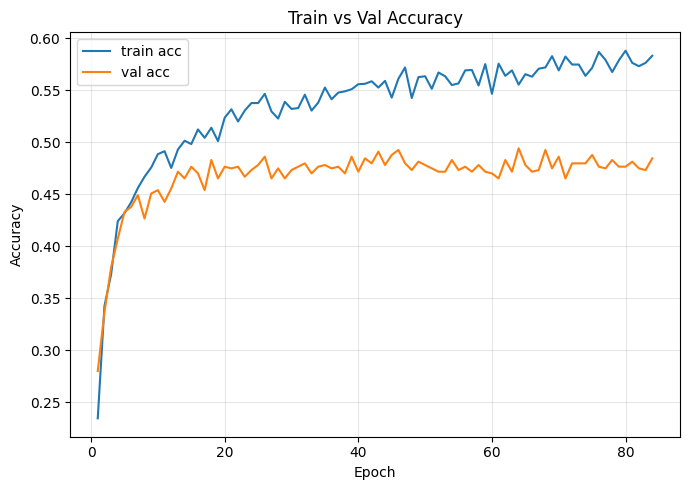

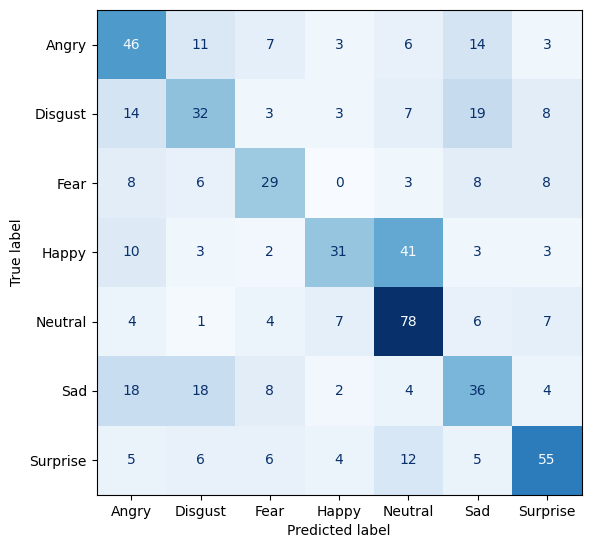

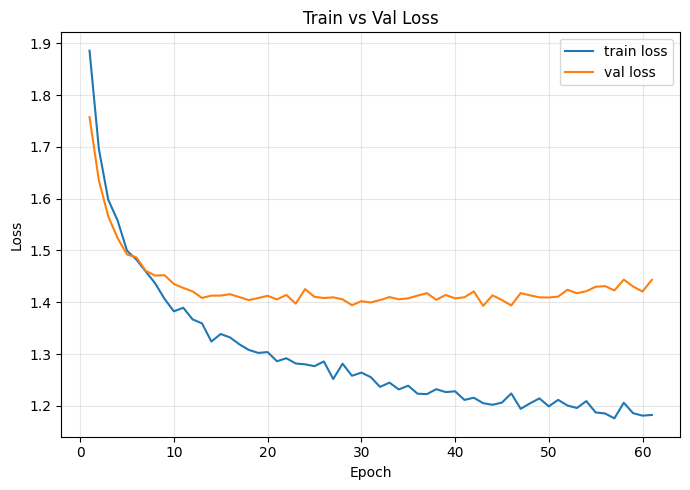

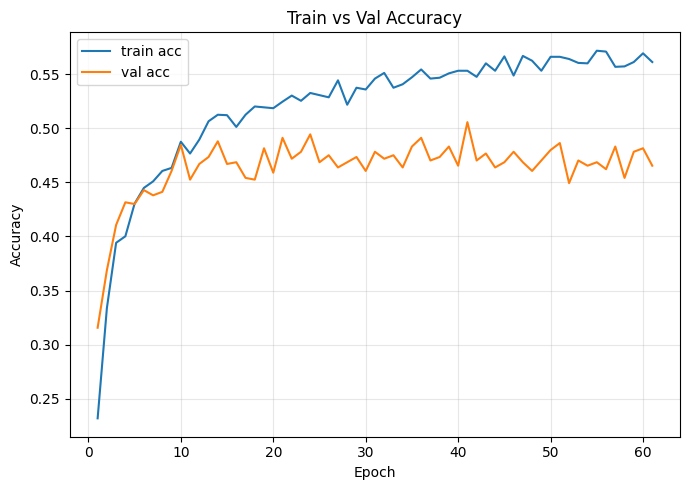

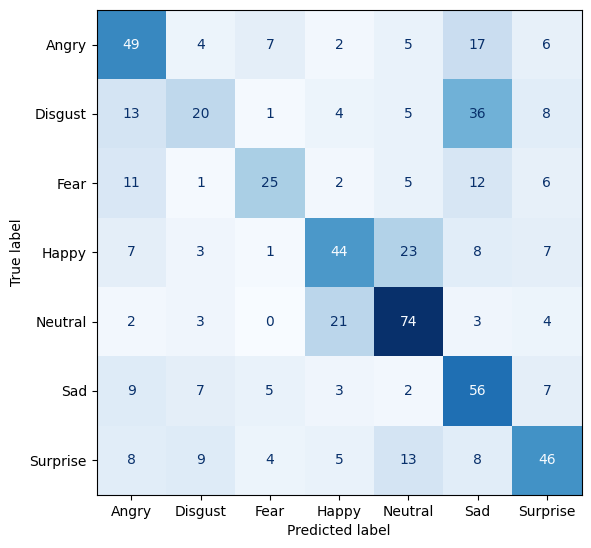

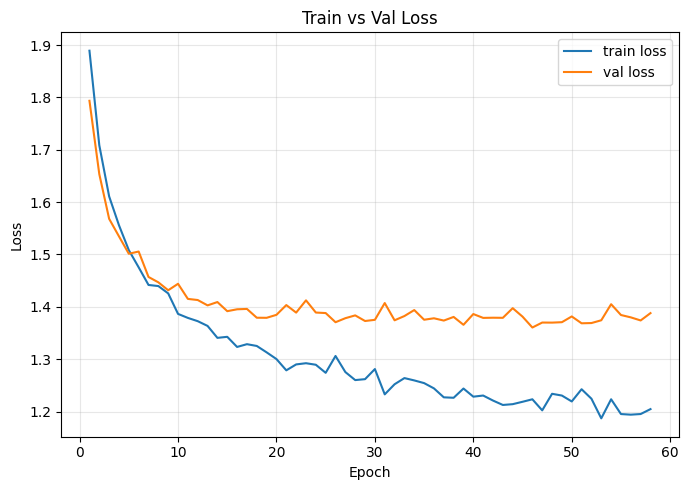

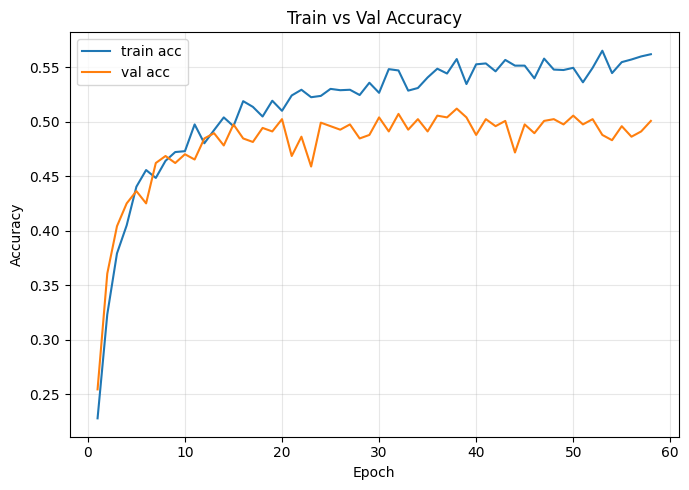

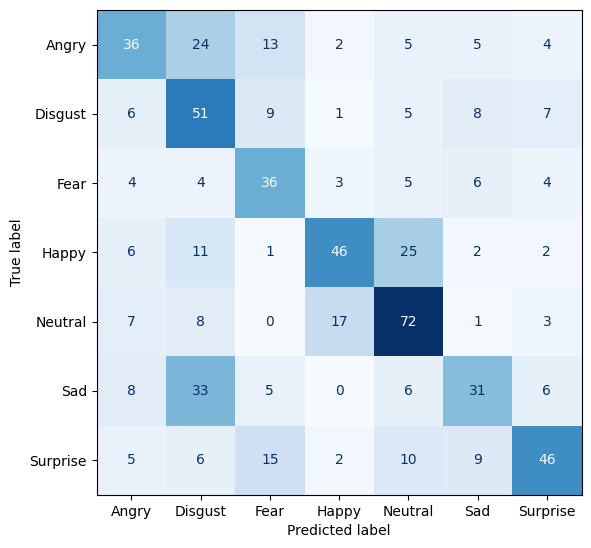

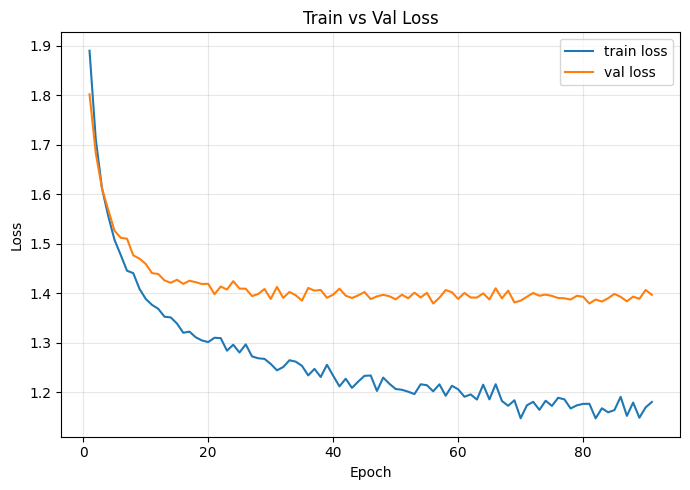

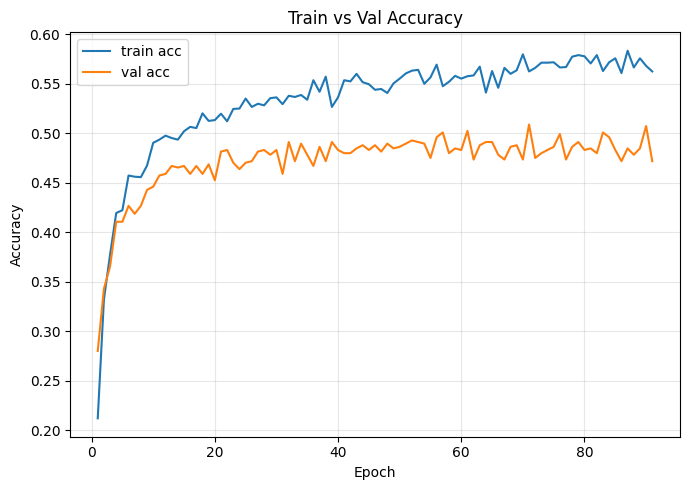

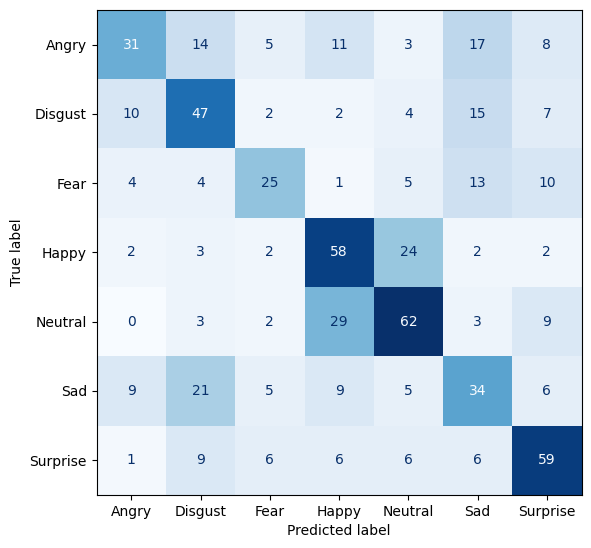

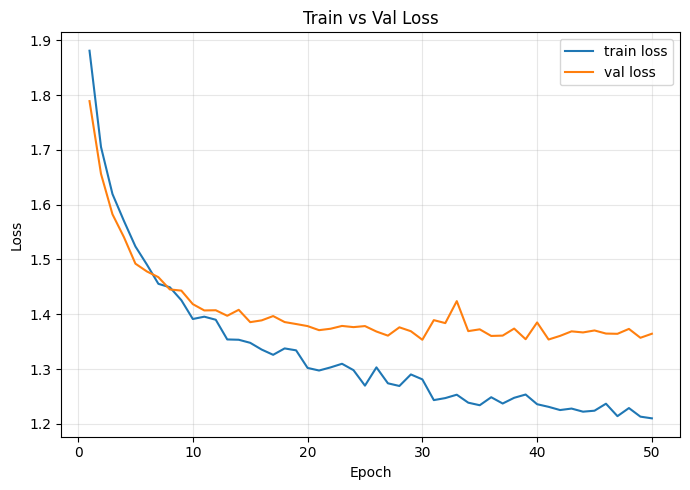

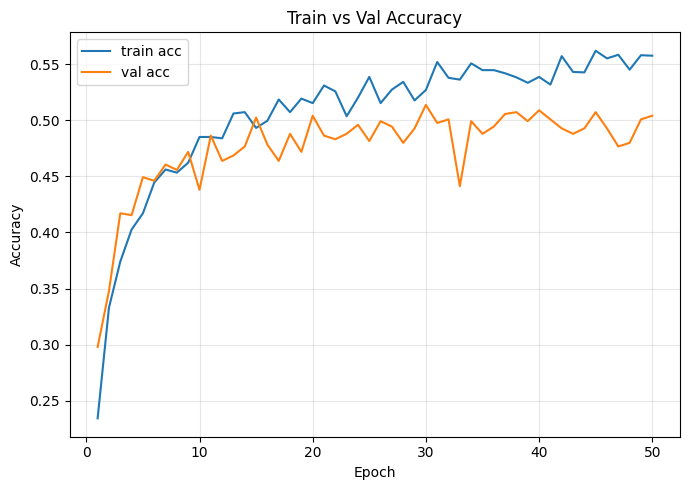

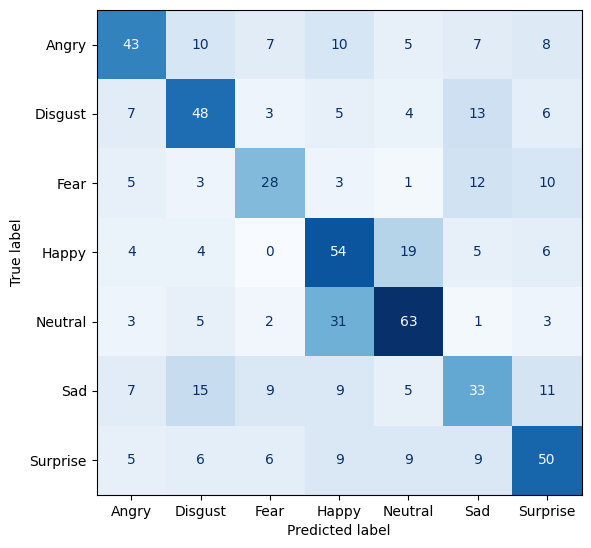

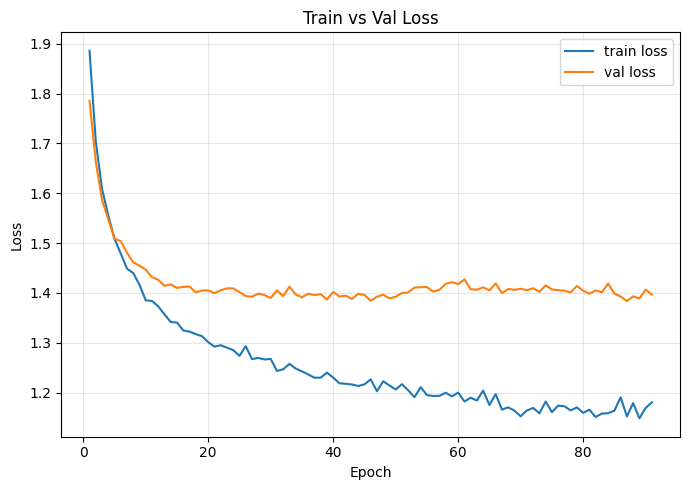

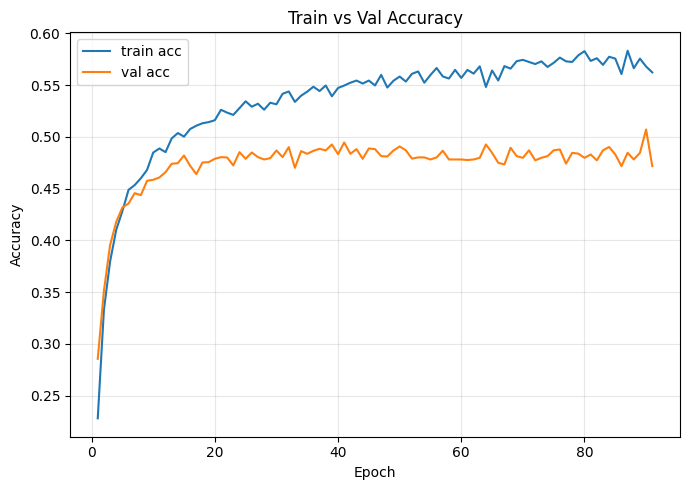

In [17]:
# Define your arguments here
my_arch = "resnet18"
my_cv = 5
my_epochs = 200
my_lr = 3e-4
my_freeze = True

# Call main with your arguments
%cd {model_dir}
main(arch=my_arch, epochs=my_epochs, cv=my_cv, lr=my_lr, freeze_backbone=my_freeze)

overfitted after 20 epochs

To Do (in general, no neccessarily for the baseline model):
 - swap for more comprehensive dataset
 - **stronger augmentation**
 - **test unfrozen backbone**
 - **regularize: dropout**
 - tune lr (1e-4, 5e-5)
 - ~~implement early stop~~
 - ~~cross-validation~~ --> ensemble?

# Evaluation

In [ ]:
# load model and inference



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_on_test(model_path, test_csv, criterion, img_size=224, arch="resnet18", batch_size=64, output_dir="test/classification"):
    '''
    Load test data and evaluate model on it.
    '''
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    ckpt = torch.load(model_path, map_location=device)
    label2id = ckpt["label2id"]          # critical for consistent class indices
    classes = sorted(label2id, key=lambda k: label2id[k])

    df_test = pd.read_csv(test_csv).reset_index(drop=True)
    # Rename the 'cropped_file_path' column to 'file_path' for consistency with ImageDataset
    if 'cropped_file_path' in df_test.columns:
        df_test = df_test.rename(columns={'cropped_file_path': 'file_path'})
    # Rename the 'category' column to 'emotion' for consistency with ImageDataset
    if 'category' in df_test.columns:
        df_test = df_test.rename(columns={'category':'emotion'})


    _, test_transform = build_transforms_train(img_size)

    test_ds = ImageDataset(
        df_test,
        label_col="emotion",
        label2id=label2id,
        transform=test_transform,
        dropna_labels=True,
    )
    test_loader = DataLoader(test_ds, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory=True)
    # load model
    model = build_model(arch, num_classes=len(label2id), pretrained=False).to(device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()


    with torch.no_grad():
      test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)

    # Get the unique labels present in the true and predicted values
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    # Get the corresponding class names for these unique labels
    unique_class_names = [classes[i] for i in unique_labels]


    rep = classification_report(y_true, y_pred, target_names=unique_class_names, labels=unique_labels, digits=4)
    print("\n[TEST] classification report:\n", rep)

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_class_names)

    output_dir += '_' + arch
    out = Path(output_dir)
    out.mkdir(parents=True, exist_ok=True)
    with open(out / "test_classification_report.txt", "w") as f:
        f.write(rep)

    plt.figure(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca(), colorbar=False)
    plt.tight_layout()
    plt.savefig(out / "test_confusion_matrix.png", dpi=150)

    # Optionally return raw arrays for custom analysis
    return {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "y_true": y_true,
        "y_pred": y_pred,
        "classes": classes,
        "report_path": str(out / "test_classification_report.txt"),
        "cm_path": str(out / "test_confusion_matrix.png"),
    }

In [ ]:
# test_csv = model_dir + "test_with_crops.csv"
# model_path = model_dir + "runs/classification_resnet18/best_overall.pt"

# criterion = nn.CrossEntropyLoss()
# evaluate_on_test(model_path, test_csv, criterion)

# Task
The emotion distribution in the combined dataset is as follows:
- Angry: 430
- Disgust: 424
- Sad: 424
- Surprise: 405
- Fear: 306
- Happy: 101
- Neutral: 91

## Display Combined Emotion Value Counts

### Subtask:
Display the value counts of the 'emotion' column in the `combined_df` to see the distribution of emotions across all merged datasets.


**Reasoning**:
Display the value counts of the 'emotion' column in `combined_df` to show the distribution of emotions.

